<p><center><font size ="6.5", face ="Times New Roman">NetFlix Market Cap Time Series Analysis</font></center></p>

<center><font size ="5", face ="Times New Roman">Instructor: Arthur Small</font></center>

<center><font size ="5", face ="Times New Roman">Author: Qimin Luo</font></center>

#  *Abstract*

<p><font size ="4", face ="Times New Roman">Netflix is one of the most successful video websites in the United States. Futher, it is also the most profitable video website in the world. It is interesting to explore its future development. In this experiment, we apply Prophet procedure to build a time series model and make preditions about its future market cap. Additionally, we also use GARCH model to fit data which is popular in the finance field. Further, we make preditions based on the best model.</font></p>

# Introduction

<p><font size ="4", face ="Times New Roman">Netflix is already one of the biggest media companyies in the world. Depsite this, there are some fast-growing media companies like Hulu, Youtube is running after it. We are interested to explore its future development. We plan to apply Prophet procedure to build a time series model to predict its future market cap. Its future development is impossible to be determined only by market cap. However, it is expected to find out some clues about future car development trend.</font></p>

# The Data and Data Generating Process

In [61]:
import warnings
warnings.filterwarnings('ignore')

In [62]:
import quandl as ql
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import fbprophet as fb

In [5]:
ql.ApiConfig.api_key = 'L1SeDskg7iEAdJ62rRTv'

<p><font size ="4", face ="Times New Roman">It is a pretty complicated and time-consuming process to retrive and well-structured data from Internet manully. In this
case, I use a convenient python financial data package -- Quandl. It contains almost unlimited financial data.
Further, it can provide us with well-formated data.</font></p>


In [6]:
data = ql.get('WIKI/NFLX')

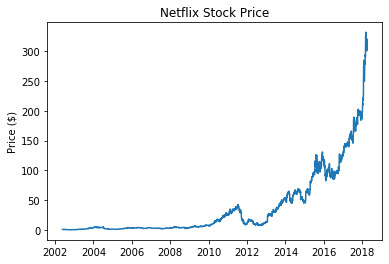

In [7]:
plt.plot(data.index, data['Adj. Close'])
plt.title('Netflix Stock Price')
plt.ylabel('Price ($)');
plt.show()

<p><font size ="4", face ="Times New Roman">The market cap of a company can be affected by lots of variables. It is reason take variables like daily stock
prices and stock vlomue into account. However, some social and political event can also have crucial effecs on
market cap. We are not able to add these things into model so we have to skip these unpredictable factors. </font></p>

<p><font size ="4", face ="Times New Roman">In this case, it is clear that variables like open price, daily highest price, daily lowest price and close price have
directive influence on its market cap. Further, stock volume is also important because it is not fair to determine
market cap by its stock price. For example, some companies have very high stock prices but its stock volume is
small. In this case, its market cap is limited by volume. Addtionally, we conisder some adjusted factors like Adj.
High since adjusted variables sometimes can demonstrate information clearly. </font></p>

$Cap\ value\ =\ Adj.Close\ Price\ *\ Stock\ volume $

In [8]:
nflx_shares = {2005: 459e6, 2006:484e6, 2007:482e6, 2008:440e6, 2009:409e6, 2010:380e6, 2011:381e6, 2012:412e6, 2013:425e6, 2014:432e6, 2015:436e6, 2016: 439e6, 2017:447e6, 2018:451e6}

In [9]:
data['Year'] = data.index.year

In [10]:
data = data[data['Year'] >= 2005]

In [11]:
data.reset_index(level=0, inplace = True)
data['cap'] = 0

In [12]:
data.head(5)

,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,Year,cap
0,2005-01-03,12.48,12.60,11.52,11.92,1619200.0,0.0,1.0,1.782857,1.800000,1.645714,1.702857,11334400.0,2005,0
1,2005-01-04,11.92,11.95,11.25,11.66,2478900.0,0.0,1.0,1.702857,1.707143,1.607143,1.665714,17352300.0,2005,0
2,2005-01-05,11.74,11.74,11.09,11.20,1818900.0,0.0,1.0,1.677143,1.677143,1.584286,1.600000,12732300.0,2005,0
3,2005-01-06,11.20,11.37,11.01,11.05,1181900.0,0.0,1.0,1.600000,1.624286,1.572857,1.578571,8273300.0,2005,0
4,2005-01-07,11.11,11.55,11.00,11.12,1070100.0,0.0,1.0,1.587143,1.650000,1.571429,1.588571,7490700.0,2005,0


In [13]:
for i, year in enumerate(data['Year']):
    
    shares = nflx_shares.get(year)
    data['cap'][i] = shares * data['Adj. Close'][i]

# Exploratory Data Analysis

## Data Format

In [14]:
nflx = data[['Date', 'cap']].copy()

nflx['cap'] = nflx['cap'] / 1e9

nflx.head()


,Date,cap
0,2005-01-03,0.781611
1,2005-01-04,0.764563
2,2005-01-05,0.734400
3,2005-01-06,0.724564
4,2005-01-07,0.729154


## Visualization of Cap Value

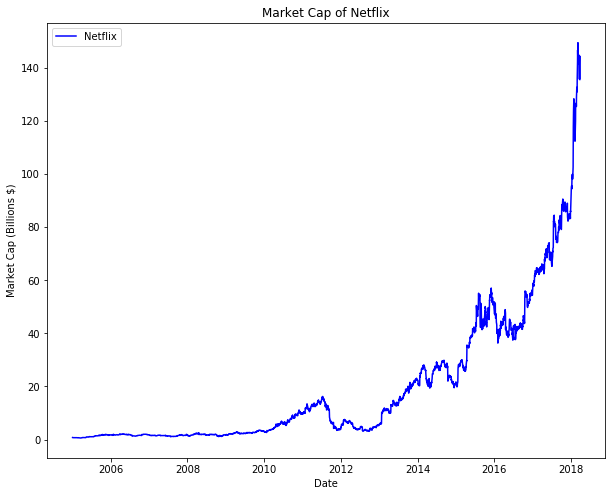

In [15]:
plt.figure(figsize=(10, 8))
plt.plot(nflx['Date'], nflx['cap'], 'b-', label = 'Netflix')
plt.xlabel('Date'); plt.ylabel('Market Cap (Billions $)'); plt.title('Market Cap of Netflix')
plt.legend();

In [16]:
nflx = nflx.rename(columns={'Date': 'ds', 'cap': 'y'})

# Data Analysis

## Statistical Model

## FB Prophet

### Formal Model

<p><font size ="4", face ="Times New Roman">Prophet Model can be roughly represented by these formulas below.</font></p>


$ y(t) = g(t) + h(t) + s(t) + \epsilon{(t)} $

$ g(t) = (k + \alpha (t)\delta)\cdot t+(m+\alpha(t)^{T}\gamma)$ （1）

$ s(t) = \sum_{n=1}^{N}(a_{n}cos(\frac{2\pi nt}{p}) + b_{n}sin(\frac{2\pi nt}{p})) $ （2）

$ h(t) = Z(t) \textbf{k} $ （3）

$ Z(t) = [1(t\in D_{1}),...,1(t\in D_{L})], \textbf{k} = (k_{1},...,k_{L})^{T}$

### Model Discussion

<p><font size ="4", face ="Times New Roman">I decide to apply Prophet Model which is explored by Facebook. Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. The financial data usually have seasonal variations and it also related with holidays. Therefore, I think this model might fit the data well.</font></p>

### Model Fitting Process

In [17]:
nf_prophet = fb.Prophet(changepoint_prior_scale=0.85, daily_seasonality=True)
nf_prophet.fit(nflx)

In [18]:

nf_forecast = nf_prophet.make_future_dataframe(periods=365 * 2, freq='D')


nf_forecast = nf_prophet.predict(nf_forecast)


#### Prediction Visualization

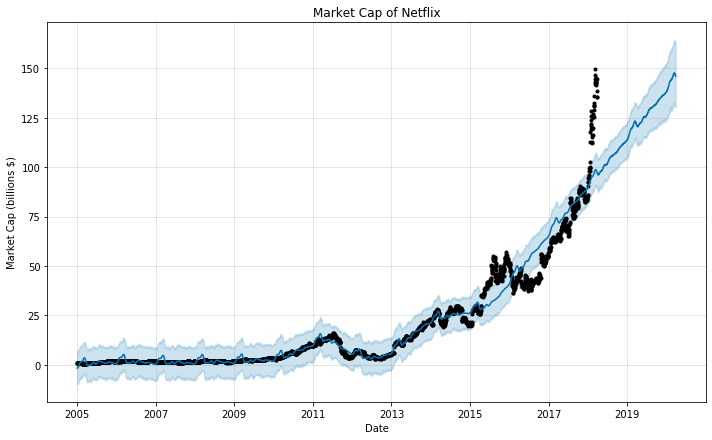

In [19]:
nf_prophet.plot(nf_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of Netflix');

### Data Transformation

#### Log Transformation

In [20]:
nf_log = nflx.copy()

In [21]:
nf_log.head(5)

,ds,y
0,2005-01-03,0.781611
1,2005-01-04,0.764563
2,2005-01-05,0.734400
3,2005-01-06,0.724564
4,2005-01-07,0.729154


In [22]:
nf_log['y'] = nf_log['y'].map(lambda x: np.log(x))

In [23]:
nf_log.head(5)

,ds,y
0,2005-01-03,-0.246398
1,2005-01-04,-0.268451
2,2005-01-05,-0.308701
3,2005-01-06,-0.322185
4,2005-01-07,-0.315870


In [24]:
nf_log_prophet = fb.Prophet(changepoint_prior_scale=0.85, daily_seasonality=True)
nf_log_prophet.fit(nf_log)

In [25]:

nf_log_forecast = nf_log_prophet.make_future_dataframe(periods=365 * 2, freq='D')


nf_log_forecast = nf_log_prophet.predict(nf_forecast)


#### Prediction Visualization

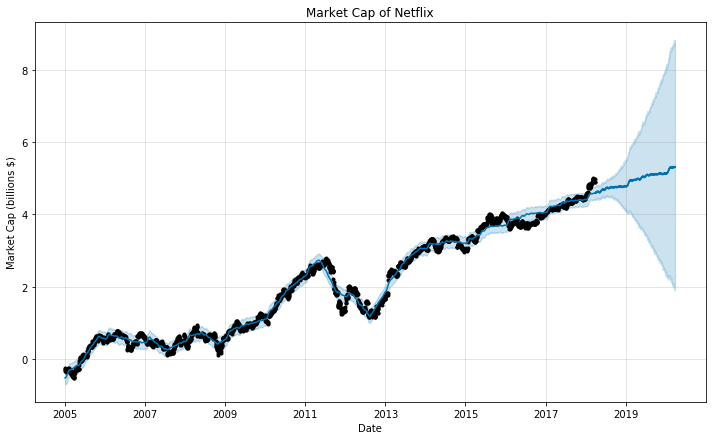

In [26]:
nf_log_prophet.plot(nf_log_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of Netflix');

### Stationary Test Functions

In [27]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    
    rol_mean = timeSeries.rolling(window=size).mean()
    
    rol_weighted_mean = pd.DataFrame.ewm(timeSeries, span=size).mean()

    timeSeries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()

'''
　　Unit Root Test
   The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
   root, with the alternative that there is no unit root. That is to say the
   bigger the p-value the more reason we assert that there is a unit root
'''
def testStationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput


def draw_acf_pacf(ts, lags=31):
    ##plt.figure(figsize=(12, 8))
    
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.tight_layout()
    plt.show()

## ARIMA Model

In [28]:
nflx.head(6)

,ds,y
0,2005-01-03,0.781611
1,2005-01-04,0.764563
2,2005-01-05,0.734400
3,2005-01-06,0.724564
4,2005-01-07,0.729154
5,2005-01-10,0.738990


In [29]:
arima_data = nflx.copy()
arima_data.set_index('ds', inplace = True)

In [30]:
ts = arima_data['y'].copy()
testStationarity(ts)

Test Statistic                    3.982803
p-value                           1.000000
#Lags Used                       29.000000
Number of Observations Used    3300.000000
Critical Value (1%)              -3.432333
Critical Value (5%)              -2.862416
Critical Value (10%)             -2.567236
dtype: float64

In [31]:
ts_log = np.log(ts).copy()
testStationarity(ts_log)

Test Statistic                   -0.198435
p-value                           0.938708
#Lags Used                        1.000000
Number of Observations Used    3328.000000
Critical Value (1%)              -3.432316
Critical Value (5%)              -2.862409
Critical Value (10%)             -2.567233
dtype: float64

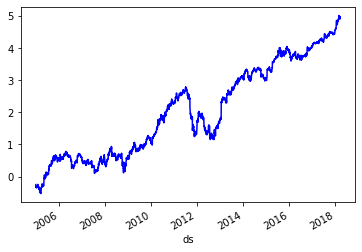

In [32]:
draw_ts(ts_log)

### PCF and ACF Test

In [34]:
arima_log = arima_data.copy()

In [35]:
arima_log['y'] = arima_log['y'].map(lambda x: np.log(x))

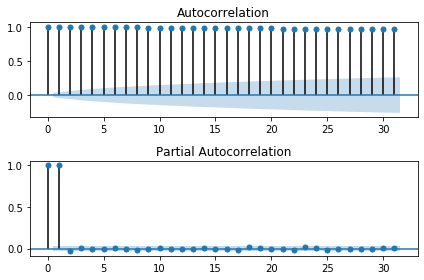

In [36]:
draw_acf_pacf(ts_log)

### Stepwise ARIMA

In [37]:
from pmdarima.arima import auto_arima

In [38]:
stepwise_model = auto_arima(ts_log, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=False,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13128.434, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13125.762, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13129.650, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13129.888, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13120.728, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-13128.933, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-13127.072, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-13125.435, Time=0.18 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.530 seconds
-13129.887914062423


## GARCH Model

In [39]:
from arch import arch_model

### Formal Model

<p><font size ="4", face ="Times New Roman">The autoregressive conditional heteroscedasticity (ARCH) model is a statistical model for time series data that describes the variance of the current error term or innovation as a function of the actual sizes of the previous time periods' error terms[1]; often the variance is related to the squares of the previous innovations. The ARCH model is appropriate when the error variance in a time series follows an autoregressive (AR) model; if an autoregressive moving average (ARMA) model is assumed for the error variance, the model is a generalized autoregressive conditional heteroskedasticity (GARCH) model[2].</font></p>

$r_{t} = c_{1}+\sum^{R}_{i=1}\phi_{i} r_{t-i} + \sum_{j=1}^{M}\phi_{j}\epsilon_{t-j} + \epsilon_{t}$

$\epsilon_{t} = u_{t}\sqrt{h_t}$

$h_{t} = k + \sum_{i=1}^{q}G_{i}h_{t-i} + \sum_{j=1}^{p}A_{i}\epsilon_{t-i}^2$

### Model Discussion

<p><font size ="4", face ="Times New Roman">ARCH models are commonly employed in modeling financial time series that exhibit time-varying volatility and volatility clustering, i.e. periods of swings interspersed with periods of relative calm. ARCH-type models are sometimes considered to be in the family of stochastic volatility models, although this is strictly incorrect since at time t the volatility is completely pre-determined (deterministic) given previous values[3].
In this case, the variance of stock prices is not constant so the traditional regression model is not feasible here. The variance of stock price is likely to vary with time. Therefore, GARCH model maybe be suitable in this case.</font></p>

### Model Fitting Process

In [40]:
nf_arch = arch_model(ts)

In [41]:
res = nf_arch.fit(update_freq=0)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 8919.93199267234
            Iterations: 24
            Function evaluations: 150
            Gradient evaluations: 24


In [42]:
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.464
Mean Model:             Constant Mean   Adj. R-squared:                 -0.464
Vol Model:                      GARCH   Log-Likelihood:               -8919.93
Distribution:                  Normal   AIC:                           17847.9
Method:            Maximum Likelihood   BIC:                           17872.3
                                        No. Observations:                 3330
Date:                Tue, Nov 24 2020   Df Residuals:                     3326
Time:                        18:14:26   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.7959  2.807e-02     63.985      0.000 [  1.741,  1.85

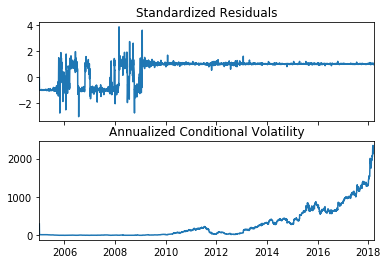

In [43]:
fig1 = res.plot(annualize='D')

### Plot Function

In [44]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [45]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

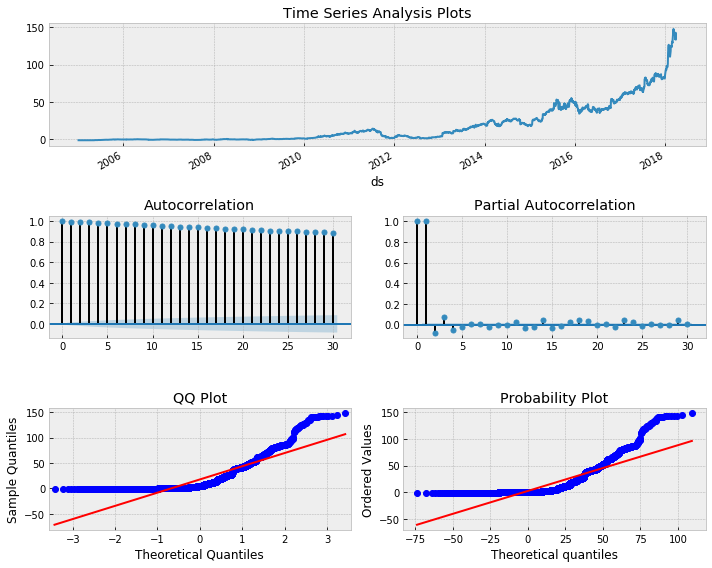

In [46]:
tsplot(res.resid, lags=30)

<p><font size ="4", face ="Times New Roman">The plots indicates that the current model didn't fit the data well. Moreover, the autocorrelations are pretty high and went down slowly. Based on that, we can conclude that we need do some data transformations. Firstly, we tried the log transformation.</font></p>

#### Log Transformation

In [47]:
nf_log_arch = arch_model(ts_log)

In [48]:
res_log = nf_log_arch.fit(update_freq=0)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3968.960141154397
            Iterations: 26
            Function evaluations: 165
            Gradient evaluations: 25


In [49]:
print(res_log.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.925
Mean Model:             Constant Mean   Adj. R-squared:                 -0.925
Vol Model:                      GARCH   Log-Likelihood:               -3968.96
Distribution:                  Normal   AIC:                           7945.92
Method:            Maximum Likelihood   BIC:                           7970.36
                                        No. Observations:                 3330
Date:                Tue, Nov 24 2020   Df Residuals:                     3326
Time:                        18:14:47   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.6481  6.483e-03     99.964      0.000 [  0.635,  0.66

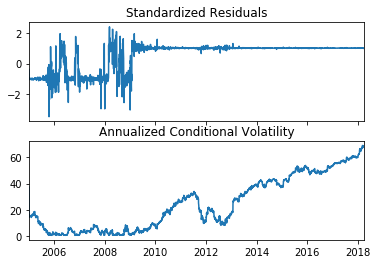

In [50]:
fig = res_log.plot(annualize='D')

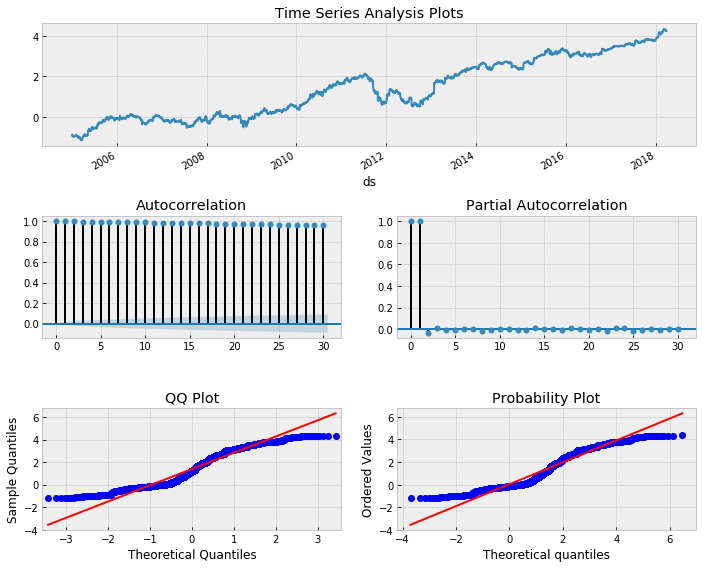

In [51]:
tsplot(res_log.resid, lags=30)

<p><font size ="4", face ="Times New Roman">According to the QQ plot, the model fitted transformed data much better. However, the autocorrelation problems still exist. Therefore, we have to try the other transformation. In this case, we applied difference transformation here.</font></p>

### Difference Function

In [52]:
## diff func
def diff(y):
    base = y[0]
    tmp = y[0]
    n = len(y)
    ret = [];
    ret.append(0);
    for i in range(1, n):
        ret.append(y[i] - tmp)
        tmp = y[i]
    return base, ret

### Difference Transformation

In [53]:
base, ts_diff = diff(ts)

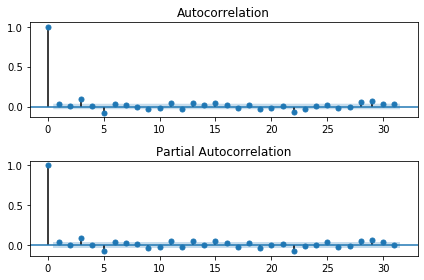

In [54]:
draw_acf_pacf(ts_diff)

In [55]:
nf_diff_arch = arch_model(ts_diff)

In [56]:
res_diff = nf_diff_arch.fit(update_freq=0)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1082.0226568370804
            Iterations: 15
            Function evaluations: 86
            Gradient evaluations: 11


In [57]:
print(res_diff.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.002
Mean Model:             Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                      GARCH   Log-Likelihood:               -1082.02
Distribution:                  Normal   AIC:                           2172.05
Method:            Maximum Likelihood   BIC:                           2196.49
                                        No. Observations:                 3330
Date:                Tue, Nov 24 2020   Df Residuals:                     3326
Time:                        18:15:11   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.8502e-03  2.282e-03      1.249      0.212 

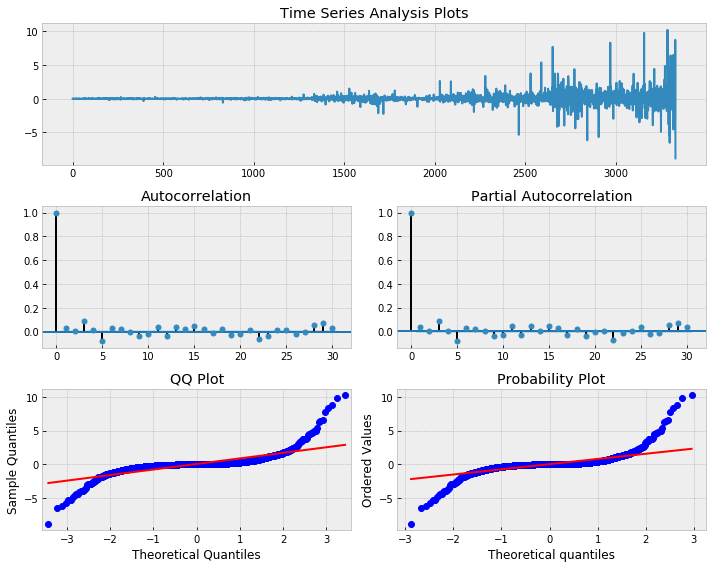

In [58]:
tsplot(res_diff.resid, lags=30)

<p><font size ="4", face ="Times New Roman">Based on the results, the autocorrelation plot and the partial autocorrelation plots seem much better. Further, the QQ plot noted that the current model fitted data well. </font></p>

# Prediction

## GARCH Simulation Forecasts

<p><font size ="4", face ="Times New Roman">Simulation-based forecasts use the model random number generator to simulate draws of the standardized residuals, $e_{t+h}$. These are used to generate a pre-specified number of paths of the variances which are then averaged to produce the forecasts. In models like GARCH which evolve in the squares of the residuals, there are few advantages to simulation-based forecasting. </font></p>

<p><font size ="4", face ="Times New Roman">Assume there are $B$ simulated paths. $A$ single simulated path is generated using</font></p>

$\sigma_{t+h,b}^2 = \omega + \alpha \epsilon_{t+h-1,b}^2 + \beta \sigma_{t+h-1,b}^2$

$\epsilon_{t+h,b} = e_{t+h,b}\sqrt{\sigma_{t+h,b}^2}$

<p><font size ="4", face ="Times New Roman">where the simulated shocks are $e_{t+1,b},e_{t+2,b},…,e_{t+h,b}$ where $b$ is included to indicate that the simulations are independent across paths. Note that the first residual, $\epsilon_{t}$, is in-sample and so is not simulated.</font></p>

<p><font size ="4", face ="Times New Roman">The final variance forecasts are then computed using the $B$ simulations</font></p>

$E_{t}[\epsilon_{t+h}^2] = \sigma_{t+h}^2 = B^{-1} \sum_{b=1}^{B} \sigma_{t+h,b}^2$

In [59]:
forecasts = res_diff.forecast(horizon=10)

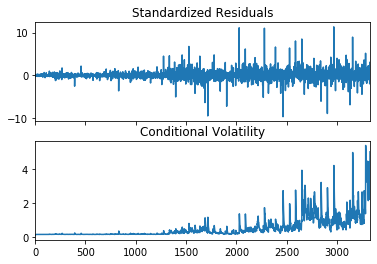

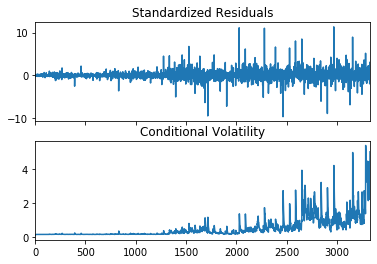

In [60]:
res_diff.plot()

In [66]:
forecasts = res_diff.forecast(horizon=10, method='simulation')

# Reference

[1] Engle, Robert F. (1982). "Autoregressive Conditional Heteroscedasticity with Estimates of the Variance of United Kingdom Inflation". Econometrica. 50 (4): 987–1007. doi:10.2307/1912773. JSTOR 1912773.
  
[2] Bollerslev, Tim (1986). "Generalized Autoregressive Conditional Heteroskedasticity". Journal of Econometrics. 31 (3): 307–327. CiteSeerX 10.1.1.468.2892. doi:10.1016/0304-4076(86)90063-1.

 
[3] Brooks, Chris (2014). Introductory Econometrics for Finance (3rd ed.). Cambridge: Cambridge University Press. p. 461. ISBN 9781107661455.
 
 [4] https://facebook.github.io/prophet/